In [1]:
!pip install PyQt5

In [2]:
!pip install imageio

P0 (inicio retraído):
    1         0         0         0.15      
   0         1         0         0         
   0         0         1         0.02      
   0         0         0         1         

P1:
    1         0         0         0.15      
   0         1         0         0         
   0         0         1        -0.05      
   0         0         0         1         

P2:
    1         0         0         0.22      
   0         1         0         0.1       
   0         0         1        -0.08      
   0         0         0         1         

P3:
    1         0         0         0.1       
   0         1         0         0.18      
   0         0         1        -0.06      
   0         0         0         1         



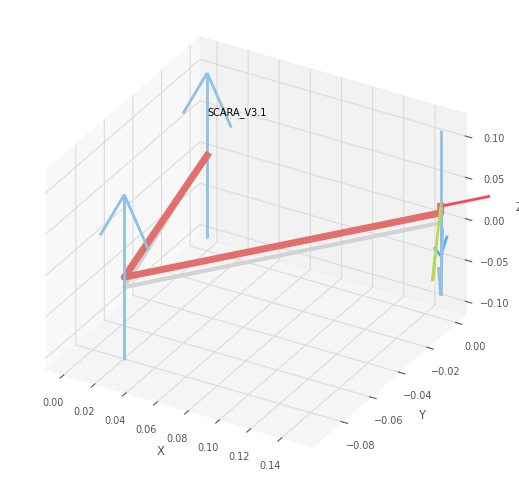

Calculando trayectoria con 150 pasos...
Paso 150/150

Generando GIF...
GIF generado: SCARA_trayectoria_3_puntos.gif
Frames guardados en: scara_trayectoria_P0_P1_P2_P3


In [13]:
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
import numpy as np
from spatialmath import SE3
import imageio
import os

# -------------------------------
# 1. Definir el robot (DH final)
# -------------------------------
L1 = rtb.RevoluteDH(
    d=0.012,
    a=0.10,
    alpha=0.0,
    qlim=[-np.pi/2, np.pi/2]    # -90° a +90°
)

L2 = rtb.RevoluteDH(
    d=0.0,
    a=0.15,
    alpha=np.pi,
    qlim=[-np.pi/2, np.pi/2]    # -90° a +90°
)

L3 = rtb.PrismaticDH(
    theta=0.0,
    a=0.0,
    alpha=0.0,
    qlim=[-0.05, 0.10]          # -5 cm a +10 cm
)

robot = rtb.DHRobot([L1, L2, L3], name="SCARA_V3.1")

# -------------------------------
# 2. Definir P0 (retraído), P1, P2, P3
# -------------------------------
# Nuevos puntos más separados para que se vean mejor:
# Todos dentro del radio 0.25 m (a1 + a2) y Z dentro de q3.

P1 = (0.15, 0.00, -0.05)   # más hacia +X
P2 = (0.22, 0.10, -0.08)   # más hacia diagonal X-Y
P3 = (0.10, 0.18, -0.06)   # más hacia +Y

T1 = SE3(*P1)
T2 = SE3(*P2)
T3 = SE3(*P3)

# Punto inicial P0: encima de P1 (retraído en Z)
T0 = SE3(P1[0], P1[1], 0.02)    # misma X,Y que P1 pero mucho más alto

print("P0 (inicio retraído):\n", T0)
print("P1:\n", T1)
print("P2:\n", T2)
print("P3:\n", T3)

mask = [1, 1, 1, 0, 0, 0]

# Verificar que P0 es alcanzable
sol0 = robot.ikine_LM(T0, mask=mask)
if not sol0.success:
    print("Advertencia: P0 no es alcanzable, revisa T0 o qlim.")
q0 = sol0.q if sol0.success else np.array([0.0, 0.0, 0.0])

# -------------------------------
# 3. Trayectorias lineales en SE3
# -------------------------------
steps_tramo = 50        # pasos por tramo (puedes subir a 60 si quieres más suave)
hold_frames = 15        # pausa más larga en P1, P2, P3

traj_01 = rtb.ctraj(T0, T1, steps_tramo)   # P0 -> P1
traj_12 = rtb.ctraj(T1, T2, steps_tramo)   # P1 -> P2
traj_23 = rtb.ctraj(T2, T3, steps_tramo)   # P2 -> P3

trajectory = list(traj_01) + list(traj_12) + list(traj_23)

end_01 = steps_tramo - 1
end_12 = 2*steps_tramo - 1
end_23 = 3*steps_tramo - 1

# -------------------------------
# 4. Preparar entorno gráfico
# -------------------------------
output_folder = "scara_trayectoria_P0_P1_P2_P3"
os.makedirs(output_folder, exist_ok=True)

q_actual = q0.copy()

env = robot.plot(q_actual, backend='pyplot', block=False)

# Límites para que se vea bien todo el workspace
env.ax.set_xlim([-0.05, 0.30])
env.ax.set_ylim([-0.05, 0.30])
env.ax.set_zlim([-0.10, 0.15])

# Vista 3D isométrica
env.ax.view_init(elev=35, azim=45)

gif_frames = []

print(f"Calculando trayectoria con {len(trajectory)} pasos...")

# -------------------------------
# 5. Bucle principal: IK + frames
# -------------------------------
for i, T_target in enumerate(trajectory):

    solucion = robot.ikine_LM(T_target, q0=q_actual, mask=mask)

    if solucion.success:
        q_actual = solucion.q

        robot.q = q_actual
        env.step()

        filename = os.path.join(output_folder, f"frame_{i:03d}.png")
        env.fig.savefig(filename)

        img = imageio.v2.imread(filename)
        gif_frames.append(img)

        # Pausa en P1, P2 y P3 para que se noten bien
        if i in [end_01, end_12, end_23]:
            for _ in range(hold_frames):
                gif_frames.append(img)

        print(f"Paso {i+1}/{len(trajectory)}", end='\r')
    else:
        print(f"\nAdvertencia: IK falló en el paso {i}.")

print("\n\nGenerando GIF...")

# -------------------------------
# 6. Crear el GIF (loop infinito)
# -------------------------------
gif_name = "SCARA_trayectoria_3_puntos.gif"

if len(gif_frames) > 0:
    # loop=0 -> repetir infinitamente
    imageio.mimsave(gif_name, gif_frames, duration=0.05, loop=0)
    print(f"GIF generado: {gif_name}")
    print(f"Frames guardados en: {output_folder}")
else:
    print("No se generaron frames. Revisa el IK o la trayectoria.")

plt.close('all')
